In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from dotenv import load_dotenv 
import random
import numpy as np
import torch
from PIL import Image
import open_clip

In [49]:
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")
RECORD_IDS_TESTING_SET = PARENT + os.getenv("RECORD_IDS_TESTING_SET")
RECORD_IDS_VALIDATION_SET = PARENT + os.getenv("RECORD_IDS_VALIDATION_SET")
WRITTEN_CAPTIONS_TESTING_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_TESTING_SET")
WRITTEN_CAPTIONS_VALIDATION_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_VALIDATION_SET")

In [66]:
def fixPath(path):
    return path.replace(".././", "../")

filtered_data_downloaded = pd.read_csv(FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED)

def get_image_path_from_recordID(recordID):
    """
    Given a recordID, return the local path for its image.
    """
    # Locate row in the downloaded DataFrame
    paths = filtered_data_downloaded[
        filtered_data_downloaded["recordID"] == recordID
    ]["low_res_filename"].values
    
    if len(paths) == 0:
        return None
    
    path = paths[0]
    # Merge: IMAGES_FOLDER + path[1:]
    merged_path = fixPath(os.path.join(IMAGES_FOLDER, path[1:]))
    return merged_path

In [50]:
setName = "validation"
DATA = pd.read_csv(WRITTEN_CAPTIONS_VALIDATION_SET) if setName == "validation" else pd.read_csv(WRITTEN_CAPTIONS_TESTING_SET)
DATA

,recordID,category,focus,caption
0,5002,Tableau,luminosity,Lumineux
1,10900,Tableau,luminosity,Lumineux
2,5510,Dessin,luminosity,Sombre
3,4576,Tableau,content,"Un paysage avec un ciel nuageux, un lac en fon..."
4,7689,Tableau,emotion,"Peur, Colère"
...,...,...,...,...
912,1294,Tableau,emotion,Peur
913,482,Tableau,colors,Couleurs sombres
914,7099,Tableau,luminosity,Neutre
915,8397,Dessin,emotion,Neutre


In [51]:
DATA[DATA["focus"]=="content"].head(10)["caption"].to_list()

['Un paysage avec un ciel nuageux, un lac en fond et un arbre en avant plan',
 'Un musicien joue de la guitare, il est assis, il a une moustache et il est jeune',
 "Un portrait d'un homme avec un chapeau noir et un habt noir, une rose derrière, moustache, ciel et batiment",
 'Un vieil homme barbu, musclé, un baton dans la main',
 'Un panier avec pommes sur une table avec une tasse, des fleurs dans un vase rouge, des livres, du papier peint',
 'Une femme de dos dans une forêt qui marche entre les arbres',
 "Jésus qui parle à des personnes, un vieil homme avec une barbe blanche, une femme avec un foulard sur la tête, deux hommes d'église",
 'Un enfant debout avec deux femmes, un homme de dos, un vase',
 'Des personnes marchent de dos dans un port, le ciel nuageux, des mats en fond, des lampadaires',
 'Deux hommes qui regardent des livres, une femme avec un enfant, un marché dans la rue']

In [52]:
DATA[DATA["focus"]=="emotion"].head(10)["caption"].to_list()

['Peur, Colère',
 'Neutre',
 'Peur',
 'Tristesse',
 'Joie',
 'Peur',
 'Joie, Surprise',
 'Peur, Colère',
 'Joie',
 'Surprise']

In [53]:
DATA[DATA["focus"]=="colors"].head(10)["caption"].to_list()

['Noir et blanc<br>(bicolor), Teinte rouge',
 'Couleurs vives, Teinte verte',
 'Neutral',
 'Noir et blanc<br>(bicolor)',
 'Noir et blanc<br>(bicolor)',
 'Couleurs vives, Teinte rouge',
 'Couleurs vives',
 'Couleurs sombres',
 'Couleurs sombres, Teinte bleue',
 'Neutre']

In [54]:
DATA[DATA["focus"]=="luminosity"].head(10)["caption"].to_list()

['Lumineux',
 'Lumineux',
 'Sombre',
 'Sombre',
 'Lumineux',
 'Lumineux',
 'Sombre',
 'Sombre',
 'Lumineux',
 'Sombre']

For the color focus, respondants could have answered "Noir et blanc (bicolor)" with a tint like "Teinte bleue", in this case we replace "Noir et blanc (bicolor)" just by "Bicolor", else we replace it by "Noir et blanc"

In [55]:
def replace_bw_captions(focus, caption):
    if focus=="colors":
        # Convert caption to list of colors
        colors = caption.split(", ")
        bw_index = -1
        for i,color in enumerate(colors):
            if color=="Noir et blanc<br>(bicolor)":
                bw_index = i
        
        if bw_index==-1:
            # Colors does not contain black and white
            return caption
        else:
            # Colors contains black and white
            if len(colors)==1:
                # Only black and white
                return "Noir et blanc"
            else:
                # Bi-color
                colors[bw_index] = "Bicolor"
                return ", ".join(colors)
                
    return caption

DATA["caption"] = DATA.apply(lambda x: replace_bw_captions(x["focus"], x["caption"]), axis=1)
DATA[DATA["focus"]=="colors"].head(10)["caption"].to_list()

['Bicolor, Teinte rouge',
 'Couleurs vives, Teinte verte',
 'Neutral',
 'Noir et blanc',
 'Noir et blanc',
 'Couleurs vives, Teinte rouge',
 'Couleurs vives',
 'Couleurs sombres',
 'Couleurs sombres, Teinte bleue',
 'Neutre']

In [56]:
models_from_open_clip = open_clip.list_models()
for model in models_from_open_clip:
    print(model)

coca_base
coca_roberta-ViT-B-32
coca_ViT-B-32
coca_ViT-L-14
convnext_base
convnext_base_w
convnext_base_w_320
convnext_large
convnext_large_d
convnext_large_d_320
convnext_small
convnext_tiny
convnext_xlarge
convnext_xxlarge
convnext_xxlarge_320
EVA01-g-14
EVA01-g-14-plus
EVA02-B-16
EVA02-E-14
EVA02-E-14-plus
EVA02-L-14
EVA02-L-14-336
MobileCLIP-B
MobileCLIP-S1
MobileCLIP-S2
mt5-base-ViT-B-32
mt5-xl-ViT-H-14
nllb-clip-base
nllb-clip-base-siglip
nllb-clip-large
nllb-clip-large-siglip
RN50
RN50-quickgelu
RN50x4
RN50x4-quickgelu
RN50x16
RN50x16-quickgelu
RN50x64
RN50x64-quickgelu
RN101
RN101-quickgelu
roberta-ViT-B-32
swin_base_patch4_window7_224
ViT-B-16
ViT-B-16-plus
ViT-B-16-plus-240
ViT-B-16-quickgelu
ViT-B-16-SigLIP
ViT-B-16-SigLIP-256
ViT-B-16-SigLIP-384
ViT-B-16-SigLIP-512
ViT-B-16-SigLIP-i18n-256
ViT-B-32
ViT-B-32-256
ViT-B-32-plus-256
ViT-B-32-quickgelu
ViT-bigG-14
ViT-bigG-14-CLIPA
ViT-bigG-14-CLIPA-336
ViT-bigG-14-quickgelu
ViT-e-14
ViT-g-14
ViT-H-14
ViT-H-14-378
ViT-H-14-378-q

In [57]:
selected_models = [
    "convnext_base",
    "ViT-B-32",
    "ViT-g-14",
    "ViT-L-14-quickgelu",
    "ViT-H-14-quickgelu",
    "ViT-H-14-378-quickgelu",
]
tokenizers = {model: open_clip.get_tokenizer(model) for model in selected_models}

In [58]:
for modelName in tokenizers.keys():
    tokenizer = tokenizers[modelName]
    DATA["tokenized_" + modelName] = DATA["caption"].apply(lambda x: len(tokenizer.encode(x)))

In [59]:
# Compare the tokenized length of the captions for each model
lengths_per_model = {modelName: DATA["tokenized_" + modelName].to_list() for modelName in tokenizers.keys()}
assert all(len(lengths_per_model[modelName])==len(lengths_per_model[selected_models[0]]) for modelName in selected_models)

All tokenizers tokenize the same !

In [60]:
# Rename the columns f"tokenized_{selected_models[0]}" to "length_tokenization"
DATA = DATA.rename(columns={f"tokenized_{selected_models[0]}": "length_tokenization"})
# Delete all "tokenized_*" columns
DATA = DATA.drop(columns=[f"tokenized_{modelName}" for modelName in selected_models[1:]])
DATA

,recordID,category,focus,caption,length_tokenization
0,5002,Tableau,luminosity,Lumineux,2
1,10900,Tableau,luminosity,Lumineux,2
2,5510,Dessin,luminosity,Sombre,2
3,4576,Tableau,content,"Un paysage avec un ciel nuageux, un lac en fon...",22
4,7689,Tableau,emotion,"Peur, Colère",5
...,...,...,...,...,...
912,1294,Tableau,emotion,Peur,2
913,482,Tableau,colors,Couleurs sombres,5
914,7099,Tableau,luminosity,Neutre,2
915,8397,Dessin,emotion,Neutre,2


In [64]:
def plot_histogram_per_focus(df, savename):
    # 2x2 plot, one histogram per focus
    ROWS_PER_FOCUS = {}
    min_token = 0
    max_token = -1

    for focus in df["focus"].unique():
        rows_for_focus = df[df["focus"]==focus]
        ROWS_PER_FOCUS[focus] = rows_for_focus
        max_token = max(max_token, rows_for_focus["length_tokenization"].max())

    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
    fig.suptitle('Tokenized length of captions per focus')
    for i, focus in enumerate(ROWS_PER_FOCUS.keys()):
        ax = axs[i//2, i%2]
        rows_for_focus = ROWS_PER_FOCUS[focus]
        mean = rows_for_focus["length_tokenization"].mean()
        ax.hist(rows_for_focus["length_tokenization"], bins=15, range=(min_token, max_token))
        ax.axvline(mean, color='r', linestyle='dashed', linewidth=1, label=f"mean: {mean:.2f}")
        ax.set_title(focus)
        ax.set_xlabel("Tokenized length")
        ax.set_ylabel("Number of captions")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.savefig(FOLDER_FIGURES + f"length_tokenization_{setName}_{savename}.pdf")
    plt.show()

Since we assume that a caption with an emotion/a color or a luminosity added is a concatenation of both, we will create such a dataset:

In [91]:
def edgeCaseEmotion(emotion):
    if emotion=="Neutre":
        emotion = "émotion neutre"
    return emotion

def edgeCaseColor(color):
    if color=="Neutre":
        color = None # The color is neutral in the sense that we do not want to specify it
    return color

def edgeCaseLuminosity(luminosity):
    if luminosity=="Neutre":
        luminosity = None # The luminosity is neutral in the sense that we do not want to specify it
    return luminosity

In [93]:
MERGED_DATA = pd.DataFrame(columns=DATA.columns)
tokenizer = tokenizers[selected_models[0]]
for i in tqdm(range(len(DATA))):
    row = DATA.iloc[i]

    recordID = row["recordID"]
    category = row["category"]
    focus = row["focus"]
    caption = row["caption"]
    length_tokenization = row["length_tokenization"]

    newRow = None

    if focus=="content":
        # Keep the caption as such
        MERGED_DATA.loc[len(MERGED_DATA)] = row.to_list()
    elif focus=="emotion":
        # Get the row with focus content for this recordID
        content_row = DATA[(DATA["recordID"]==recordID) & (DATA["focus"]=="content")].iloc[0]
        caption_content = content_row["caption"]

        # Split the emotions by ", "
        emotions = caption.split(", ")
        emotions = [edgeCaseEmotion(emotion) for emotion in emotions]

        for emotion in emotions:
            mergedCaption = f"{caption_content}, {emotion}"
            newRow = [
                recordID,
                category,
                focus, # emotion
                mergedCaption,
                len(tokenizer.encode(mergedCaption))
            ]
            MERGED_DATA.loc[len(MERGED_DATA)] = newRow
    elif focus=="colors":
        # Get the row with focus content for this recordID
        content_row = DATA[(DATA["recordID"]==recordID) & (DATA["focus"]=="content")].iloc[0]
        caption_content = content_row["caption"]

        # Split the colors by ", "
        colors = caption.split(", ")
        colors = [edgeCaseColor(color) for color in colors]
        # Remove empty strings
        colors = list(filter(None, colors))
        if len(colors)==0:
            # No colors specified
            continue

        colors = ", ".join(colors)

        mergedCaption = f"{caption_content}, {colors}"
        newRow = [
            recordID,
            category,
            focus, # colors
            mergedCaption,
            len(tokenizer.encode(mergedCaption))
        ]
        MERGED_DATA.loc[len(MERGED_DATA)] = newRow
    elif focus=="luminosity":
        # Get the row with focus content for this recordID
        content_row = DATA[(DATA["recordID"]==recordID) & (DATA["focus"]=="content")].iloc[0]
        caption_content = content_row["caption"]

        # Split the luminosities by ", "
        luminosities = caption.split(", ")
        luminosities = caption.split(", ")
        luminosities = [edgeCaseLuminosity(luminosity) for luminosity in luminosities]
        # Remove empty strings
        luminosities = list(filter(None, luminosities))
        if len(luminosities)==0:
            # No luminosities specified
            continue

        luminosities = ", ".join(luminosities)

        mergedCaption = f"{caption_content}, {luminosities}"
        newRow = [
            recordID,
            category,
            focus, # luminosity
            mergedCaption,
            len(tokenizer.encode(mergedCaption))
        ]
        MERGED_DATA.loc[len(MERGED_DATA)] = newRow

MERGED_DATA

100%|██████████| 917/917 [00:02<00:00, 457.70it/s]


,recordID,category,focus,caption,length_tokenization
0,5002,Tableau,luminosity,"Une fête, un repas, une foule en intérieur, de...",30
1,10900,Tableau,luminosity,"Une femme joue du piano, elle lit une partitio...",36
2,5510,Dessin,luminosity,"Un adolescente est assise contre le mur, elle ...",28
3,4576,Tableau,content,"Un paysage avec un ciel nuageux, un lac en fon...",22
4,7689,Tableau,emotion,"Des hommes barbus et moustachus qui discutent,...",26
...,...,...,...,...,...
958,4072,Tableau,content,"Portrait d'une jeune femme qui lit un livre, v...",24
959,1294,Tableau,emotion,Un paysage désolé avec des arbres sans feuille...,31
960,482,Tableau,colors,Portrait d'une jeune femme avec une robe noire...,33
961,8397,Dessin,emotion,"Des personnes marchent de dos dans un port, le...",32


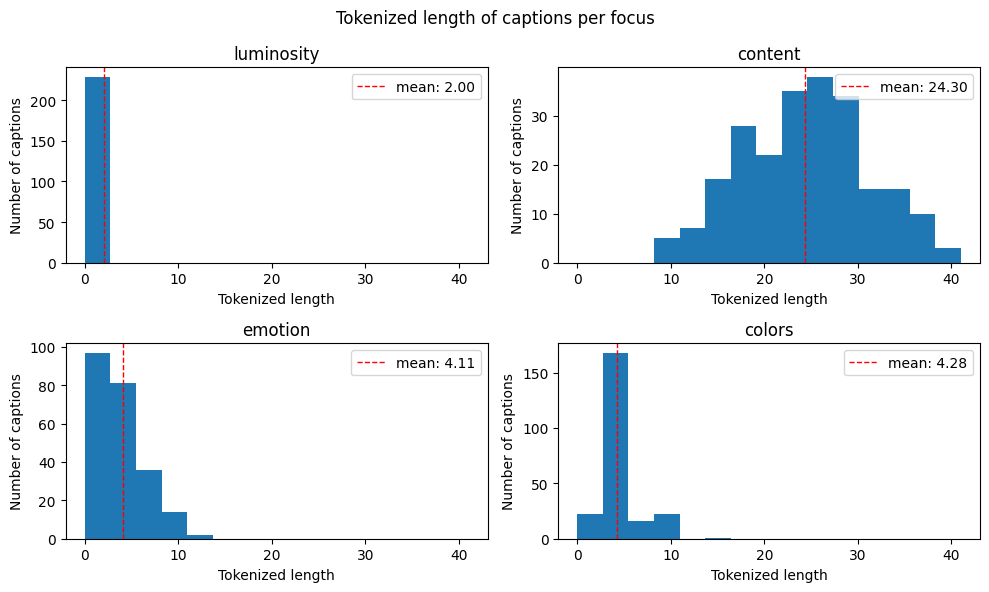

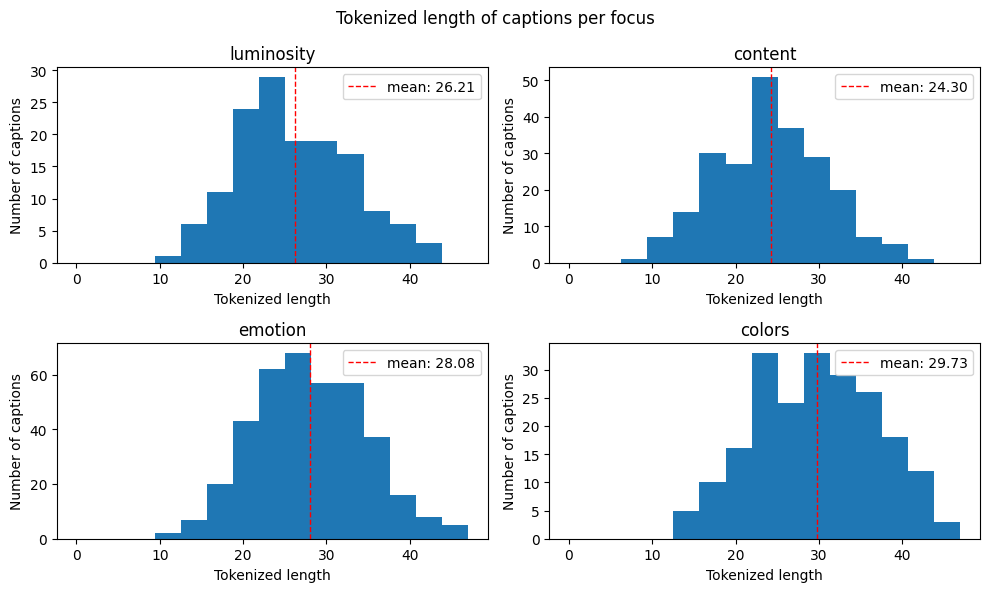

In [94]:
plot_histogram_per_focus(DATA, "original")
plot_histogram_per_focus(MERGED_DATA, "merged")

In [100]:
merged_caption_table = pd.DataFrame(columns=["Version", "Content (%)", "Emotion (%)", "Colors (%)", "Luminosity (%)"])
focus_uniques = ["Content", "Emotion", "Colors", "Luminosity"]

# Original/Raw data
merged_caption_table.loc[len(merged_caption_table)] = [
    "Original/Raw",
    len(DATA[DATA["focus"]=="content"])/len(DATA),
    len(DATA[DATA["focus"]=="emotion"])/len(DATA),
    len(DATA[DATA["focus"]=="colors"])/len(DATA),
    len(DATA[DATA["focus"]=="luminosity"])/len(DATA)
]

# Merged data
merged_caption_table.loc[len(merged_caption_table)] = [
    "Merged",
    len(MERGED_DATA[MERGED_DATA["focus"]=="content"])/len(MERGED_DATA),
    len(MERGED_DATA[MERGED_DATA["focus"]=="emotion"])/len(MERGED_DATA),
    len(MERGED_DATA[MERGED_DATA["focus"]=="colors"])/len(MERGED_DATA),
    len(MERGED_DATA[MERGED_DATA["focus"]=="luminosity"])/len(MERGED_DATA)
]

# Format the last 4 columns as percentages
for focus in focus_uniques:
    merged_caption_table[focus + " (%)"] = merged_caption_table[focus + " (%)"].apply(lambda x: f"{x*100:.2f}%")

# Save the table
merged_caption_table.to_csv(FOLDER_TABLE + "merged_caption_table.csv", index=False)
merged_caption_table

,Version,Content (%),Emotion (%),Colors (%),Luminosity (%)
0,Original/Raw,24.97%,25.08%,24.97%,24.97%
1,Merged,23.78%,39.67%,21.70%,14.85%


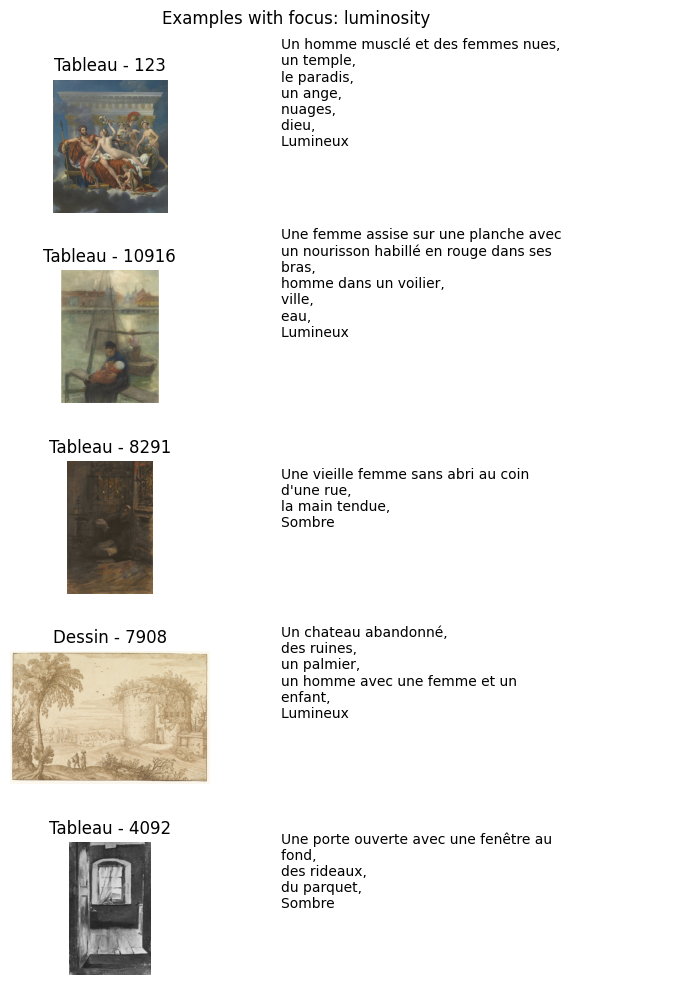

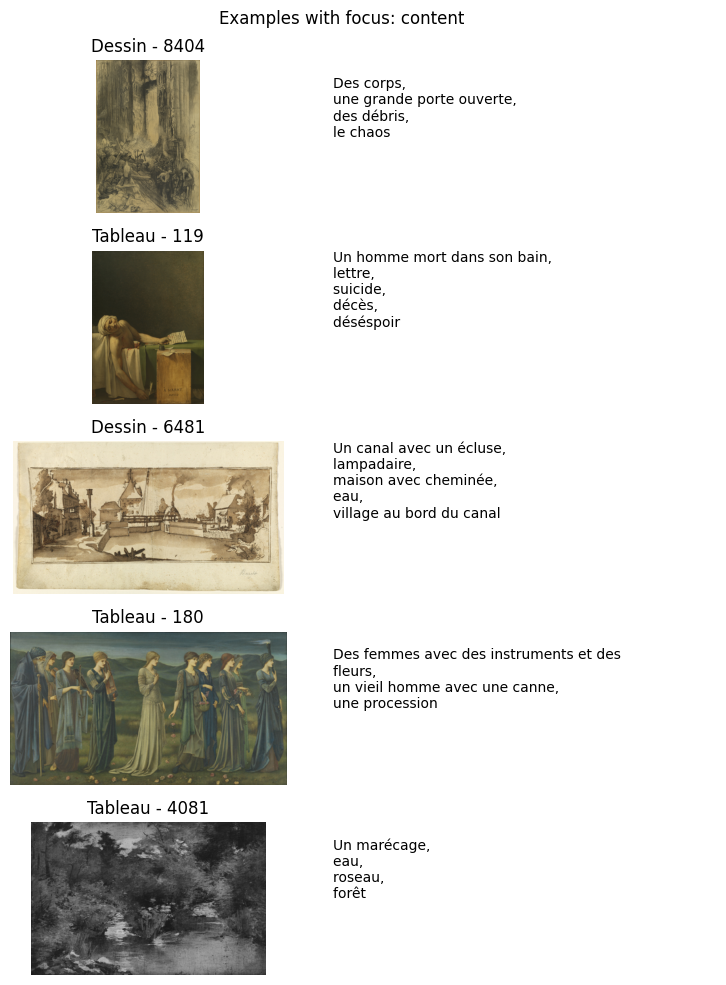

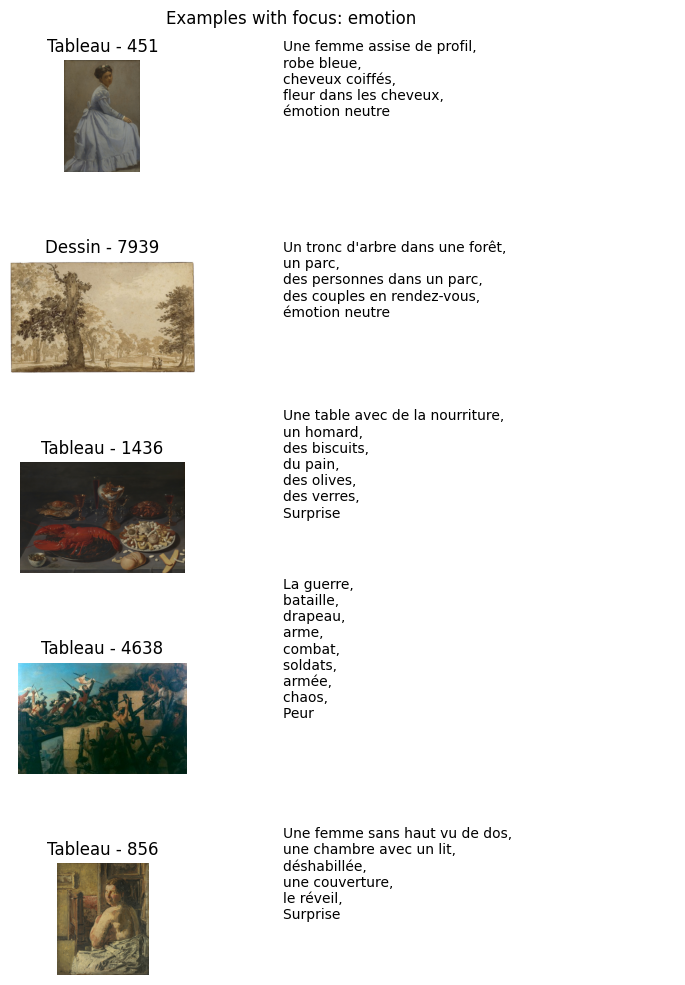

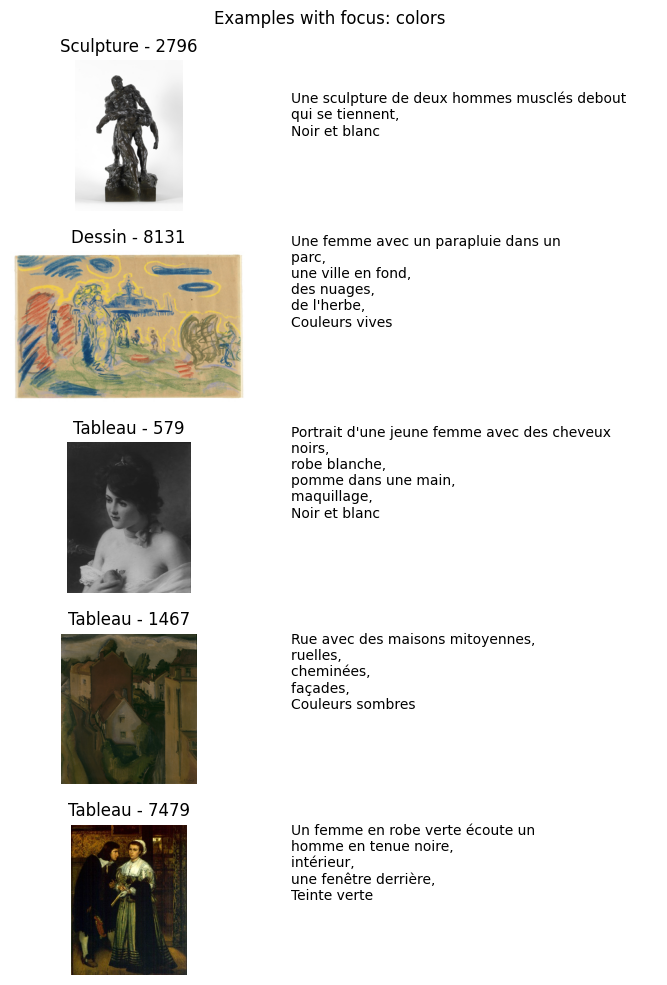

In [101]:
def formatLine(raw, maxWords=8):
    # raw is a string, add \n every maxWords words
    words = raw.split(" ")
    lines = []
    line = ""
    for word in words:
        if len(line.split(" "))==maxWords:
            lines.append(line)
            line = ""
        line += word + " "
    lines.append(line)
    return "\n".join(lines)

def formatCaption(caption):
    caption = caption.replace(", ", ",\n")
    return "\n".join([formatLine(line) for line in caption.split("\n")])

def show_N_examples_with_focus(data, N, focus):
    rows = data[data["focus"]==focus].sample(N)
    # Plot with N rows, each row contains the image on the left and the caption on the right
    fig, axs = plt.subplots(N, 2, figsize=(8, 2*N))
    fig.suptitle(f"Examples with focus: {focus}")
    for i in range(N):
        row = rows.iloc[i]
        recordID = row["recordID"]
        category = row["category"]
        caption = row["caption"]
        image_path = get_image_path_from_recordID(recordID)
        image = Image.open(image_path)
        axs[i, 0].imshow(image, cmap="gray")
        axs[i, 0].axis("off")
        axs[i, 0].set_title(f"{category} - {recordID}")
        axs[i, 1].text(0, 0.5, formatCaption(caption), fontsize=10)
        axs[i, 1].axis("off")
    plt.tight_layout()
    plt.savefig(FOLDER_FIGURES + f"examples_{focus}_{setName}.pdf")
    plt.show()

for focus in MERGED_DATA["focus"].unique():
    show_N_examples_with_focus(MERGED_DATA, 5, focus)

In [107]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [131]:
selected_models = [
    "convnext_base",
    "ViT-B-32",
    "ViT-g-14",
    "ViT-L-14-quickgelu",
    "ViT-H-14-quickgelu",
    "ViT-H-14-378-quickgelu",
]

In [137]:
selected_model = selected_models[0]
model, _, preprocess = open_clip.create_model_and_transforms(selected_model)
model = model.to(device)
model.eval()
tokenizer = open_clip.get_tokenizer(selected_model)

In [138]:
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity

class ImageTextDataset(Dataset):
    def __init__(self, dataframe, preprocess):
        self.dataframe = dataframe
        self.preprocess = preprocess

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        path = get_image_path_from_recordID(row['recordID']) 
        image = Image.open(path)
        image = self.preprocess(image)
        
        text = row['caption']
        return image, text

dataset = ImageTextDataset(MERGED_DATA, preprocess)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

print(len(dataset), len(dataloader))

963 61


In [139]:
# Compute features
image_features_list = []
text_features_list = []

with torch.no_grad():
    for images, texts in tqdm(dataloader):
        # Process images
        images = images.to(device)
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize
        image_features_list.append(image_features.cpu())

        # Process texts
        tokenized_texts = tokenizer(texts).to(device)
        text_features = model.encode_text(tokenized_texts)
        text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize
        text_features_list.append(text_features.cpu())

# Combine all features
image_features = torch.cat(image_features_list, dim=0)
text_features = torch.cat(text_features_list, dim=0)

# Convert to numpy arrays for cosine similarity calculation
image_features_np = image_features.numpy()
text_features_np = text_features.numpy()

100%|██████████| 61/61 [00:10<00:00,  5.67it/s]


In [140]:
# Compute cosine similarity for each row
cosine_similarities = [
    cosine_similarity(
        image_features_np[i].reshape(1, -1), 
        text_features_np[i].reshape(1, -1)
    )[0, 0]
    for i in range(len(MERGED_DATA))
]

# Add similarities to the DataFrame
MERGED_DATA['cosine_similarity'] = cosine_similarities
MERGED_DATA['cosine_similarity'].describe()

count    963.000000
mean      -0.001265
std        0.029808
min       -0.086791
25%       -0.021995
50%       -0.004702
75%        0.021121
max        0.093804
Name: cosine_similarity, dtype: float64

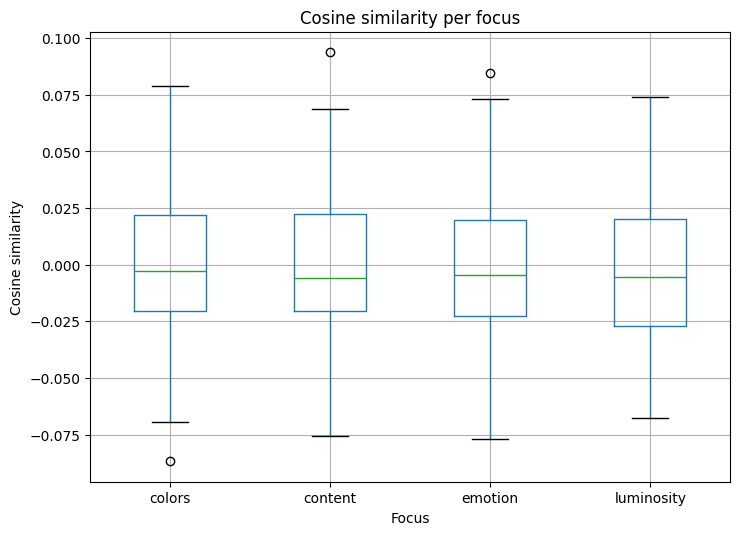

In [141]:
# Boxplot of cosine similarities per focus
fig, ax = plt.subplots(figsize=(8, 6))
ax = MERGED_DATA.boxplot(column='cosine_similarity', by='focus', ax=ax)
plt.suptitle('')
plt.title('Cosine similarity per focus')
plt.ylabel('Cosine similarity')
plt.xlabel('Focus')
plt.savefig(FOLDER_FIGURES + f"cosine_similarity_per_focus_{setName}.pdf")
plt.show()